# Libraries

In [1]:
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
import time

# Data Preparation

In [2]:
data = pd.read_csv("train.csv")
data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [4]:
# Defien features and labels
X = data.drop("label", axis=1).values
Y = data.label.values
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(35700, 784) (6300, 784)
(35700,) (6300,)


torch.Size([35700, 1, 28, 28])
torch.Size([35700])


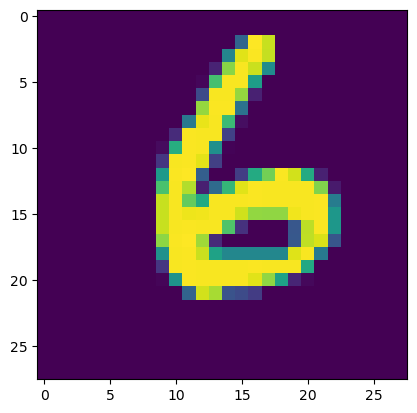

tensor(6)


In [5]:
# Convert data to suitable form
tensor_x_train = torch.Tensor(x_train).view(-1, 1, 28, 28).float()
tensor_y_train = torch.Tensor(y_train).long()
print(tensor_x_train.shape)
print(tensor_y_train.shape)
t = 1
plt.imshow(tensor_x_train[t][0])
plt.show()
print(tensor_y_train[t])
tensor_x_test = torch.Tensor(x_test).view(-1, 1, 28, 28).float()
tensor_y_test = torch.Tensor(y_test).long()

In [6]:
# Prepare dataset
train_set = TensorDataset(tensor_x_train, tensor_y_train)
test_set = TensorDataset(tensor_x_test, tensor_y_test)
x, y = train_set[1]
print(x[0].shape, "\n", y)

torch.Size([28, 28]) 
 tensor(6)


In [7]:
BATCH_SIZE = 64
train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, BATCH_SIZE, shuffle=False)
print(len(train_loader), 6)

558 6


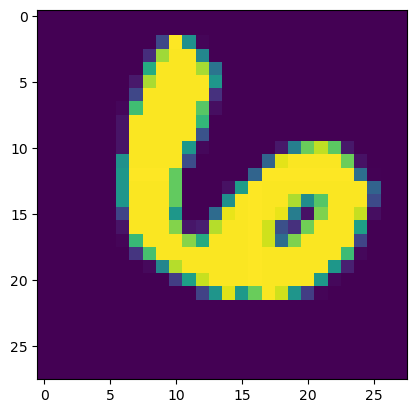

tensor(6)


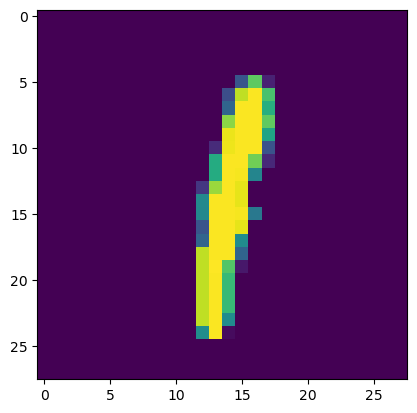

tensor(1)


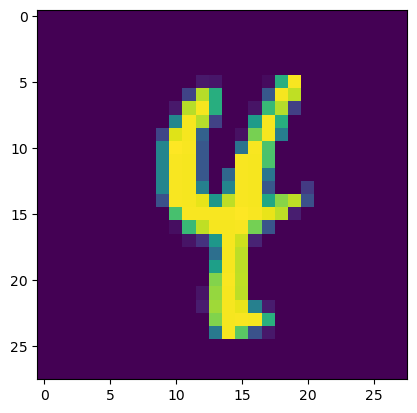

tensor(4)


In [8]:
x = 0
for data, target in train_loader:
    plt.imshow(data[0][0])
    plt.show()
    print(target[0])
    x += 1
    if x == 3:
        break
   


# NETWORK

In [9]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1)
        self.linear = nn.Linear(32 * 10 * 10, 10)  

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.linear(x.view(-1, 32 * 10 * 10)) 
        return nn.functional.log_softmax(x, dim=1)


# Train Function

In [10]:
def train(model, train_loader, test_loader, epochs=5, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []
    accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        test_loss = 0.0
        correct = 0.0
        total = 0.0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_losses.append(test_loss / len(test_loader))
        accuracy = correct / total
        accuracies.append(accuracy)

        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Train Loss: {train_losses[-1]:.4f}, '
              f'Test Loss: {test_losses[-1]:.4f}, '
              f'Accuracy: {100 * accuracy:.2f}%')

# CONCLUSION

In [11]:
model = CNN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

EPOCH = 2
train(model, train_loader, test_loader, EPOCH)

Epoch [1/2], Train Loss: 0.4049, Test Loss: 0.2081, Accuracy: 94.98%
Epoch [2/2], Train Loss: 0.1271, Test Loss: 0.1077, Accuracy: 97.30%
